<a href="https://colab.research.google.com/github/wolframalexa/FrequentistML/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: [UCI ML Repository Breast Cancer Dataset](https://https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

This dataset contains information about skin masses and whether they are cancerous. The goal is to apply logistic regression to determine whether a mass of cells is cancerous or not.

In [ ]:
#----------IMPORT PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
#----------DATA READING 

data = 'https://raw.githubusercontent.com/wolframalexa/FrequentistML/master/datasets/breast-cancer-wisconsin.csv'
col_names=['ID','clump_thickness','cell_sz_unif','cell_shape_unif','marginal_adhesion','epi_cell_sz','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']
dataframe = pd.read_table(data, sep=',',header=None,names=col_names,na_values='?')

In [ ]:
#----------CLEAN DATA

# Add column to account for intercept 
ones_col = np.ones(len(dataframe))
dataframe.insert(0, "intercept", ones_col, True) 

# Drop rows with missing data
clean_data = dataframe.dropna(axis=0)

# Adjust class - 0 is benign, 1 is malignant
clean_data['class'] = (clean_data['class']-2)/2

# Show data information                    
clean_data.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,intercept,ID,clump_thickness,cell_sz_unif,cell_shape_unif,marginal_adhesion,epi_cell_sz,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,683.0,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.0,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,0.0,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.0,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.0,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,1.0,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,1.0,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,1.0,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [ ]:
#----------SEPARATE DATA

# Choose seed
np.random.seed(420)

# Separate training and testing data
train_data, validate_data, test_data = np.split(clean_data.sample(frac=1), [int(.8*len(clean_data)), int(.9*len(clean_data))])

# Separate training inputs and outputs
x_train = train_data.drop(['class','ID'], axis=1)  
y_train = train_data['class']

# Separate validation inputs and outputs
x_val = validate_data.drop(['class','ID'], axis=1)  
y_val = validate_data['class']

# Separate testing inputs and outputs
x_test = test_data.drop(['class','ID'], axis=1)
y_test = test_data['class']


# Normalize testing validation and training inputs
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min()) 
x_train.intercept = np.ones(len(x_train))
x_val = (x_val-x_val.min())/(x_val.max()-x_val.min()) 
x_val.intercept = np.ones(len(x_val))
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min()) 
x_test.intercept = np.ones(len(x_test))

In [ ]:
#------------LOGISTIC REGRESSION WITH STOCHASTIC GRADIENT DESCENT
# set initial thetas
thetas = np.ones(len(x_train.columns))

# for plotting later
likelihood_no_reg = np.ones([1,1000])[0]

# use stochastic gradient descent
for i in range(1000):
  alpha=0.01 # step size
  h = 1/(1 + np.exp(-np.dot(x_train,np.transpose(thetas))))
  error = y_train - h
  thetas = thetas + alpha * np.dot(error,x_train)

  # for plotting later, calculate likelihood function
  likelihood_no_reg[i] = np.multiply(h**y_train,(np.ones(h.shape)-h)**(1-y_train))[0]

print("Logistic regression coefficients:",thetas)

Logistic regression coefficients: [-7.36995746  5.06161463  0.36119204  2.62576041  2.41971287  0.60631737
  3.56808679  4.81282288  2.52051775  3.22786641]


In [ ]:
# score on test set
benchmark = 0.5 # set decision boundary

# apply thetas 
logistic_sga_predicted = 1/(1 + np.exp(-np.dot(x_test,np.transpose(thetas))))
logistic_sga_predicted_class = [0 if i<=benchmark else 1 for i in logistic_sga_predicted]

# XOR lists together to find where classes are different, and divide by length to get % incorrect
pred_incorrect = sum(list(map(bool,logistic_sga_predicted_class)) ^ y_test.astype('bool'))/len(logistic_sga_predicted_class) 
print("Percent of incorrect predictions:",pred_incorrect*100,"%")

Percent of incorrect predictions: 2.898550724637681 %


The decision boundary was set at 0.5, meaning that if there was more than a 50% chance that the cells were malignant, they were marked as such, otherwise, they were marked as benign. Of course, this number may change in the real world (it may make more sense to tell people they have cancer when you are more sure, or if you are aggressive, you may want to order further tests even if there is a smaller chance it is cancer). The model, using logistic regression, has a 2% error rate on the test dataset.

In [ ]:
#------------LOGISTIC REGRESSION WITH SGD AND REGULARIZATION
# set initial thetas
thetas_reg = np.ones((1000, len(x_train.columns))) # one row for each lambda

# set vector of lambdas
lambdas = np.linspace(0, 0.1, num=10) # I want to test more smaller values than larger values

# initialize scoring vector
vals = np.zeros(lambdas.shape)

# set likelihood vector
likelihood_reg = np.ones((1,1000))[0]

# use stochastic gradient descent for each lambda
alpha=0.01 # step size
benchmark = 0.5

for index,lam in enumerate(lambdas):
  for i in range(1000):
    h = 1/(1 + np.exp(-np.dot(x_train,np.transpose(thetas_reg[index]))))
    error = y_train - h

    # update thetas using SGD and L2 regularization penalty
    thetas_reg[index] = thetas_reg[index] + alpha * np.dot(error,x_train) - lam * 2 * thetas_reg[index]

    # for plotting later, calculate likelihood function
    likelihood_reg[i] = np.multiply(h**y_train,(np.ones(h.shape)-h)**(1-y_train))[0]

  log_sgd_reg_pred = 1/(1 + np.exp(-np.dot(x_val,np.transpose(thetas_reg[index]))))
  log_sgd_reg_pred_class = [0 if i<=benchmark else 1 for i in log_sgd_reg_pred]

  # XOR lists together to find where classes are different, and divide by length to get % incorrect
  pred_incorrect = sum(list(map(bool,log_sgd_reg_pred_class)) ^ y_val.astype('bool'))/len(log_sgd_reg_pred_class) 
  vals[index] = pred_incorrect

# Find lambda that minimizes error on val set
minpos = np.where(vals == vals.min())
minpos = minpos[0][0] # choose first one if many local minima
best_lam = lambdas[minpos]

print("Best lambda chosen on validation set:",best_lam)
thetas_reg_best = thetas_reg[minpos]
print("Best coefficients chosen on validation set:",thetas_reg_best)

# Apply new thetas to test set and score
log_sgd_reg_pred = 1/(1 + np.exp(-np.dot(x_test,np.transpose(thetas_reg_best))))
log_sgd_reg_pred_class = [0 if i<=benchmark else 1 for i in log_sgd_reg_pred]

# XOR lists together to find where classes are different, and divide by length to get % incorrect
pred_incorrect_sgd = sum(list(map(bool,log_sgd_reg_pred_class)) ^ y_test.astype('bool'))/len(log_sgd_reg_pred_class) 
print("Percent of incorrect predictions:",pred_incorrect_sgd*100,"%")

Best lambda chosen on validation set: 0.0
Best coefficients chosen on validation set: [-7.36995746  5.06161463  0.36119204  2.62576041  2.41971287  0.60631737
  3.56808679  4.81282288  2.52051775  3.22786641]
Percent of incorrect predictions: 2.898550724637681 %


Using stochastic gradient descent, we chose the best $\lambda$ value by minimizing the cost function. In the case where multiple values minimized the function, we chose the first. With an error rate of approximately 3%, only two cases are misidentified, which is the same percentage as logistic regression without SGD. Because the test dataset only has 69 entries, this percentage could certainly change with a larger dataset.

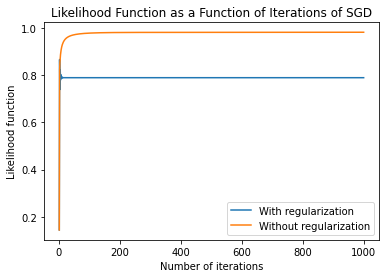

In [ ]:
#-------PLOT LIKELIHOOD FUNCTION

# prepare iterations
i_graph = np.linspace(1,1000,num=1000)

fig = plt.figure()

likelihood_reg = np.transpose(likelihood_reg)
likelihood_no_reg = np.transpose(likelihood_no_reg)

plt.plot(i_graph,likelihood_reg)
plt.plot(i_graph,likelihood_no_reg)

plt.title('Likelihood Function as a Function of Iterations of SGD')
plt.ylabel('Likelihood function')
plt.xlabel('Number of iterations')
plt.legend(['With regularization', 'Without regularization'], loc='lower right')
plt.show()

The likelihood function converges slightly faster for the method without regularization than the method that uses it, but this was likely lucky - it turns out that the $\theta$ coefficients are relatively close to the "ones" matrix used initially. Using a matrix full of 100s yields different results, where the regularization method converges after the method without. The method with regularization converges to a lower likelihood of 0.8, whereas the method without regularization converges to approximately 1. Regularization avoids overfitting of the model, which could be why it converges to a lower likelihood - because it penalizes large parameters, the model performs better on data in the real world, but that means it may sacrifice some accuracy on the training set.